<a href="https://colab.research.google.com/github/MatiasCostanzo2726/BigDataUBA-Grupo9/blob/main/Big_Data_TP4_Grupo9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [4]:
from google.colab import files

uploaded = files.upload()

Saving df_unido.xlsx to df_unido.xlsx


In [14]:
from google.colab import files

uploaded = files.upload()

Saving respondieron.csv to respondieron.csv


In [16]:
# Leer el archivo Excel correctamente
df = pd.read_excel("df_unido.xlsx")

In [17]:
# Crear la nueva columna "edad²" con los valores al cuadrado
# Renombrar la columna "edad" a "edad2"
df.rename(columns={"ch06": "edad2"}, inplace=True)
df["edad²"] = df["edad2"] ** 2
df["mujer"] = (df["ch04"] == 2).astype(int)  # 2 = Mujer, 1 = Varón
df["horastrab"] = df["pp3e_tot"] + df["pp3f_tot"]
# Aplicar el coeficiente de ajuste
df["p21"] = df["p21"].astype(float)  # Convertir a float antes de modificar
df.loc[df["ano4"] == 2004, "p21"] *= 314.621568
# Calcular el salario semanal
df["salario_semanal"] = df["p21"] / 40
# Función para calcular años de educación
def calcular_educ(row):
    if row["ch12"] == 2:  # Primario
        return row["ch14"]
    elif row["ch12"] == 4:  # Secundario
        return 12 if row["ch13"] == 1 else row["ch14"]
    elif row["ch12"] == 6:  # Terciario
        return 15 if row["ch13"] == 1 else 12 + row["ch14"]
    elif row["ch12"] == 7:  # Universitario
        return 17 if row["ch13"] == 1 else 12 + row["ch14"]
    elif row["ch12"] == 9:  # Educación especial
        return None  # No comparable
    else:
        return None  # Ns/Nr u otro valor

# Aplicar la función al DataFrame
df["educ"] = df.apply(calcular_educ, axis=1)
df.rename(columns={"ch06": "edad2"}, inplace=True)
# Crear la variable dependiente (y) a partir de estado
df["desocupado"] = (df["estado"] == 2).astype(int)  # 2 = Desocupado, 1 = Ocupado

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Variables a usar como X
X_vars = ["edad2", "edad²", "educ", "mujer", "horastrab"]

respondieron = df

# Función para aplicar el proceso por año
def validar_por_anio(respondieron, anio):
    print(f"\n======= Año {anio} =======")

    base_anio = respondieron[respondieron["ano4"] == anio].copy()

    X = base_anio[X_vars]
    X = sm.add_constant(X)
    y = base_anio["desocupado"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=444)

    # Tabla de diferencias de medias
    tabla_diff = pd.DataFrame({
        "Media Train": X_train.mean(),
        "Media Test": X_test.mean(),
        "Diferencia": X_train.mean() - X_test.mean()
    })

    print(tabla_diff)


    print("\nComentario")
    print("Las diferencias de medias entre los conjuntos de entrenamiento y prueba son pequeñas, lo que sugiere que la partición aleatoria mantiene representatividad. Esto es importante para evitar sesgos al entrenar el modelo.")

# Aplicar por año
for anio in [2004, 2024]:
    validar_por_anio(respondieron, anio)




======= Año 2004 =======
           Media Train   Media Test  Diferencia
const         1.000000     1.000000    0.000000
edad2        31.285250    31.505336   -0.220086
edad²      1448.619488  1474.614779  -25.995291
educ         10.119381    10.209348   -0.089967
mujer         0.524163     0.521086    0.003076
horastrab    15.148287    14.904909    0.243378

Comentario
Las diferencias de medias entre los conjuntos de entrenamiento y prueba son pequeñas, lo que sugiere que la partición aleatoria mantiene representatividad. Esto es importante para evitar sesgos al entrenar el modelo.

======= Año 2024 =======
           Media Train   Media Test  Diferencia
const         1.000000     1.000000    0.000000
edad2        36.356022    36.147293    0.208729
edad²      1810.690203  1810.417559    0.272644
educ         10.155353     9.942539    0.212814
mujer         0.521778     0.515127    0.006651
horastrab    36.272734    37.133775   -0.861041

Comentario
Las diferencias de medias entre los

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Función para correr los cinco modelos para ocupados de cada año
def modelos_lineales_ocupados(df, anio):
    print(f"\n======= Año {anio} =======")

    df_anio = df[(df["ano4"] == anio) & (df["estado"] == 1)].copy()

    # Eliminar filas con NaN en las variables que usaremos
    variables_todas = ["edad2", "edad²", "educ", "mujer", "horastrab", "salario_semanal"]
    df_anio = df_anio.dropna(subset=variables_todas)

    # Definir matriz X y variable objetivo y
    X = df_anio[["edad2", "edad²", "educ", "mujer", "horastrab"]]
    y = df_anio["salario_semanal"]

    # Dividir entre train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

    # Modelos secuenciales
    modelos = {
        "Modelo i": ["edad2"],
        "Modelo ii": ["edad2", "edad²"],
        "Modelo iii": ["edad2", "edad²", "educ"],
        "Modelo iv": ["edad2", "edad²", "educ", "mujer"],
        "Modelo v": ["edad2", "edad²", "educ", "mujer", "horastrab"]
    }

    for nombre, variables in modelos.items():
        reg = LinearRegression()
        reg.fit(X_train[variables], y_train)
        y_pred = reg.predict(X_test[variables])

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = reg.score(X_test[variables], y_test)

        print(f"\n--- {nombre} ---")
        print("Variables:", variables)
        print(f"R²: {r2:.4f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")

# Aplicar para 2004 y 2024
for anio in [2004, 2024]:
    modelos_lineales_ocupados(respondieron, anio)



======= Año 2004 =======

--- Modelo i ---
Variables: ['edad2']
R²: 0.0164
MSE: 71747765.30
RMSE: 8470.41
MAE: 3277.45

--- Modelo ii ---
Variables: ['edad2', 'edad²']
R²: 0.0210
MSE: 71417979.26
RMSE: 8450.92
MAE: 3234.52

--- Modelo iii ---
Variables: ['edad2', 'edad²', 'educ']
R²: 0.0278
MSE: 70921067.35
RMSE: 8421.46
MAE: 3187.88

--- Modelo iv ---
Variables: ['edad2', 'edad²', 'educ', 'mujer']
R²: 0.0452
MSE: 69646264.18
RMSE: 8345.43
MAE: 3089.62

--- Modelo v ---
Variables: ['edad2', 'edad²', 'educ', 'mujer', 'horastrab']
R²: 0.0462
MSE: 69575648.23
RMSE: 8341.20
MAE: 3079.27

======= Año 2024 =======

--- Modelo i ---
Variables: ['edad2']
R²: 0.0102
MSE: 69052233.28
RMSE: 8309.77
MAE: 4833.51

--- Modelo ii ---
Variables: ['edad2', 'edad²']
R²: 0.0221
MSE: 68224319.20
RMSE: 8259.80
MAE: 4763.33

--- Modelo iii ---
Variables: ['edad2', 'edad²', 'educ']
R²: 0.0221
MSE: 68225791.18
RMSE: 8259.89
MAE: 4757.83

--- Modelo iv ---
Variables: ['edad2', 'edad²', 'educ', 'mujer']
R²: 0.

In [20]:
from sklearn.model_selection import train_test_split

# Filtramos solo quienes respondieron y tienen salario_semanal válido
respondieron_filtrado = respondieron.dropna(subset=["salario_semanal", "edad2", "edad²", "educ", "mujer", "horastrab"])

# Dividimos train y test (estratificando por año para mantener proporción)
train, test = train_test_split(respondieron_filtrado, test_size=0.3, random_state=42, stratify=respondieron_filtrado["ano4"])

In [24]:
#3
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import statsmodels.api as sm
import pandas as pd

def validar_modelos(train, test, anio):
    print(f"\n===== Regresión Año {anio} =====")

    df_train = train[(train["ano4"] == anio) & (train["estado"] == 1)].dropna(subset=["salario_semanal", "edad2", "edad2_sq", "educ", "mujer", "horastrab"])
    df_test = test[(test["ano4"] == anio) & (test["estado"] == 1)].dropna(subset=["salario_semanal", "edad2", "edad2_sq", "educ", "mujer", "horastrab"])

    modelos = [
        ["edad2"],
        ["edad2", "edad2_sq"],
        ["edad2", "edad2_sq", "educ"],
        ["edad2", "edad2_sq", "educ", "mujer"],
        ["edad2", "edad2_sq", "educ", "mujer", "horastrab"]
    ]

    resultados = []

    for i, vars_x in enumerate(modelos):
        X_train = sm.add_constant(df_train[vars_x])
        y_train = df_train["salario_semanal"]
        modelo = sm.OLS(y_train, X_train).fit()

        X_test = sm.add_constant(df_test[vars_x])
        y_test = df_test["salario_semanal"]
        y_pred = modelo.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)

        resultados.append({
            "Modelo": f"Modelo {i+1}",
            "Variables": vars_x,
            "MSE": round(mse, 2),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2)
        })

    return pd.DataFrame(resultados)



====== Año 2004 ======
                            OLS Regression Results                            
Dep. Variable:        salario_semanal   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     118.4
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.64e-98
Time:                        23:32:19   Log-Likelihood:                -88711.
No. Observations:                8679   AIC:                         1.774e+05
Df Residuals:                    8674   BIC:                         1.775e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1533.3089    255

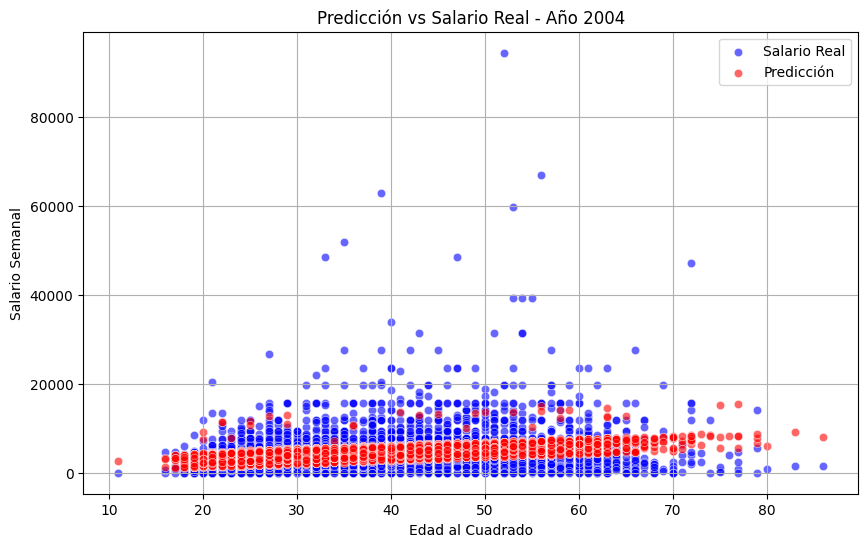


====== Año 2024 ======
                            OLS Regression Results                            
Dep. Variable:        salario_semanal   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     72.57
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           7.42e-61
Time:                        23:32:21   Log-Likelihood:            -1.2474e+05
No. Observations:               12020   AIC:                         2.495e+05
Df Residuals:                   12015   BIC:                         2.495e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4129.3330    261

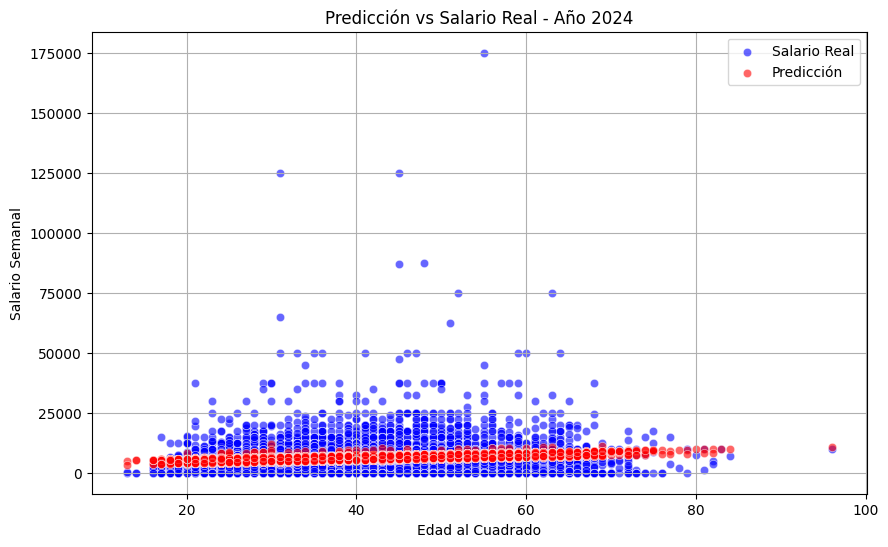

In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_prediccion_vs_real(test_df, y_pred, anio):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=test_df['edad2'], y=test_df['salario_semanal'], color='blue', label='Salario Real', alpha=0.6)
    sns.scatterplot(x=test_df['edad2'], y=y_pred, color='red', label='Predicción', alpha=0.6)
    plt.xlabel('Edad al Cuadrado')
    plt.ylabel('Salario Semanal')
    plt.title(f'Predicción vs Salario Real - Año {anio}')
    plt.legend()
    plt.grid(True)
    plt.show()

vars_mejor = ["edad2", "educ", "mujer", "horastrab"]

for anio in [2004, 2024]:
    print(f"\n====== Año {anio} ======")

    # Filtrar train y test ocupados y sin NA en variables
    train_anio = train[(train["ano4"] == anio) & (train["estado"] == 1)].dropna(subset=vars_mejor + ["salario_semanal"])
    test_anio = test[(test["ano4"] == anio) & (test["estado"] == 1)].dropna(subset=vars_mejor + ["salario_semanal"])

    # Preparar X e y para train
    X_train = sm.add_constant(train_anio[vars_mejor])
    y_train = train_anio["salario_semanal"]

    # Ajustar modelo OLS
    modelo = sm.OLS(y_train, X_train).fit()
    print(modelo.summary())

    # Preparar X para test
    X_test = sm.add_constant(test_anio[vars_mejor])

    # Predecir salario_semanal en test
    y_pred = modelo.predict(X_test)

    # Graficar predicción vs real
    graficar_prediccion_vs_real(test_anio, y_pred, anio)


In [27]:
print(train.columns.tolist())


['codusu', 'nro_hogar', 'componente', 'h15', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'edad2', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 


===== Clasificación Combinada 2004 y 2024 =====
Año Combinado - Train clases:
desocupado
0    27051
1     1357
Name: count, dtype: int64
Año Combinado - Test clases:
desocupado
0    11610
1      565
Name: count, dtype: int64

--- Regresión Logística ---
Matriz de Confusión:
[[11610     0]
 [  565     0]]
AUC: 0.9120
Accuracy: 0.9536

--- KNN (k=5) ---
Matriz de Confusión:
[[11462   148]
 [  488    77]]
AUC: 0.8182
Accuracy: 0.9478


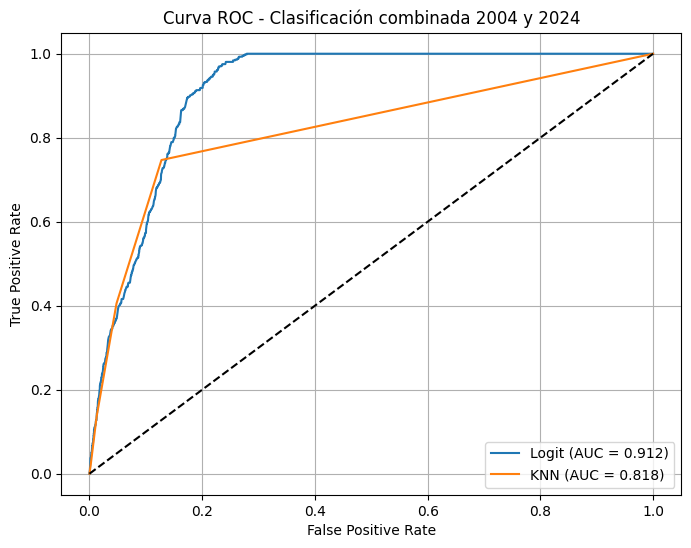

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Variables predictoras corregidas
vars_clasif = ["edad2", "edad²", "educ", "mujer", "horastrab"]

def evaluar_modelo_clasificacion(train_df, test_df):
    print("\n===== Clasificación Combinada 2004 y 2024 =====")

    # Combinar train y test
    combined_train = train_df.dropna(subset=vars_clasif + ["desocupado"])
    combined_test = test_df.dropna(subset=vars_clasif + ["desocupado"])

    print(f"Año Combinado - Train clases:\n{combined_train['desocupado'].value_counts()}")
    print(f"Año Combinado - Test clases:\n{combined_test['desocupado'].value_counts()}")

    X_train = combined_train[vars_clasif]
    y_train = combined_train["desocupado"]

    X_test = combined_test[vars_clasif]
    y_test = combined_test["desocupado"]

    # --------- Regresión Logística ---------
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X_train, y_train)
    prob_logit = logit.predict_proba(X_test)[:, 1]
    pred_logit = (prob_logit > 0.5).astype(int)

    print("\n--- Regresión Logística ---")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, pred_logit))

    auc_logit = roc_auc_score(y_test, prob_logit)
    acc_logit = accuracy_score(y_test, pred_logit)
    print(f"AUC: {auc_logit:.4f}")
    print(f"Accuracy: {acc_logit:.4f}")

    fpr_logit, tpr_logit, _ = roc_curve(y_test, prob_logit)

    # --------- KNN (k=5) ---------
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    prob_knn = knn.predict_proba(X_test)[:, 1]
    pred_knn = (prob_knn > 0.5).astype(int)

    print("\n--- KNN (k=5) ---")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, pred_knn))

    auc_knn = roc_auc_score(y_test, prob_knn)
    acc_knn = accuracy_score(y_test, pred_knn)
    print(f"AUC: {auc_knn:.4f}")
    print(f"Accuracy: {acc_knn:.4f}")

    fpr_knn, tpr_knn, _ = roc_curve(y_test, prob_knn)

    # --------- Gráfico ROC ---------
    plt.figure(figsize=(8,6))
    plt.plot(fpr_logit, tpr_logit, label=f'Logit (AUC = {auc_logit:.3f})')
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Clasificación combinada 2004 y 2024')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar el modelo con todos los datos juntos
evaluar_modelo_clasificacion(train, test)


Conclusión:
La regresión logística tiene mejor AUC y accuracy global, pero no identifica ningún desocupado en el test, lo cual es un problema serio para un modelo de clasificación binaria con clases desbalanceadas.

El KNN tiene menor AUC y accuracy, pero sí logra identificar algunos desocupados, lo que la hace más útil para detectar esa clase minoritaria, aunque con errores.

- SI el  objetivo es maximizar la capacidad de detección de desocupados, KNN es mejor porque predice esta clase.

- Si lo que importa es una alta exactitud general y buen ordenamiento según la probabilidad, la regresión logística tiene mejor performance, pero hay que ajustar el umbral o balancear clases para que también detecte desocupados.

In [30]:
from google.colab import files

uploaded = files.upload()

Saving norespondieron_filtrado.xlsx to norespondieron_filtrado (1).xlsx


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# Cargo la base norespondieron (que no está limpia)
noresp = pd.read_excel("norespondieron_filtrado.xlsx")


# Mostramos columnas para ver variables disponibles
print(noresp.columns)


Index(['codusu', 'nro_hogar', 'componente', 'h15', 'ano4', 'trimestre',
       'region', 'mas_500', 'aglomerado', 'pondera',
       ...
       'adeccfr', 'pj1_1', 'pj2_1', 'pj3_1', 'idimpp', 'ch05', 'imputa',
       'pondiio', 'pondii', 'pondih'],
      dtype='object', length=181)


In [32]:
# Edad y edad al cuadrado
noresp["edad"] = noresp["ch06"]
noresp["edad2"] = noresp["ch06"] ** 2

# Variable mujer (1 = mujer, 0 = varón)
noresp["mujer"] = noresp["ch04"].map({1: 0, 2: 1})

# Mapear años de educación según nivel educativo
mapa_educ = {
    0: 0, 1: 3, 2: 7, 3: 9, 4: 12, 5: 14, 6: 16, 7: 18, 8: 20, 9: 0
}
noresp["educ"] = noresp["nivel_ed"].map(mapa_educ)

# Horas trabajadas
noresp["horastrab"] = noresp["pp3e_tot"]


In [33]:
from google.colab import files

uploaded = files.upload()

Saving respondieron.csv to respondieron (1).csv


In [34]:
respondieron = pd.read_csv("respondieron.csv", sep=",")  # sep por defecto es coma, pero por si acaso

<ipython-input-34-2d4cf7577719>:1: DtypeWarning: Columns (0,100,103,176) have mixed types. Specify dtype option on import or set low_memory=False.
  respondieron = pd.read_csv("respondieron.csv", sep=",")  # sep por defecto es coma, pero por si acaso


In [35]:
print(respondieron.columns.tolist())
print(noresp.columns.tolist())

['codusu', 'nro_hogar', 'componente', 'h15', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', '

In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar datos
respondieron = pd.read_csv("respondieron.csv")
norespondieron = pd.read_excel("norespondieron_filtrado.xlsx")

# 2. Igualar nombres columnas clave en ambas bases
def renombrar(df):
    df = df.rename(columns={
        "ch06": "edad",
        "CH06": "edad",
        "ch04": "sexo",
        "CH04": "sexo",
        "ch12": "horastrab",
        "CH12": "horastrab",
        "estado": "estado"
    })
    return df

respondieron = renombrar(respondieron)
norespondieron = renombrar(norespondieron)

# 3. Crear variable target 'desocupado' para respondieron (estado=2)
respondieron["desocupado"] = (respondieron["estado"] == 2).astype(int)

# 4. Seleccionar variables para modelo (puedes agregar más)
vars_clasif = ["edad", "sexo", "horastrab"]

# 5. Limpiar datos: eliminar filas con NA en variables y target
respondieron_clean = respondieron.dropna(subset=vars_clasif + ["desocupado"]).copy()
norespondieron_clean = norespondieron.dropna(subset=vars_clasif).copy()

# 6. Codificar sexo (si está en números, convertir a 0/1)
# Supongamos 1=Hombre, 2=Mujer, ajusta si es necesario
def codificar_sexo(df):
    # Si 'sexo' no es 0/1, convertir 2 -> 1 (Mujer), 1 -> 0 (Hombre)
    df["sexo"] = df["sexo"].map({1: 0, 2: 1})
    return df

respondieron_clean = codificar_sexo(respondieron_clean)
norespondieron_clean = codificar_sexo(norespondieron_clean)

# 7. Unir bases para entrenamiento (solo respondieron), y luego predecir en norespondieron
# En este caso solo entrenamos con respondieron_clean y predecimos en norespondieron_clean

X_train = respondieron_clean[vars_clasif]
y_train = respondieron_clean["desocupado"]

X_pred = norespondieron_clean[vars_clasif]

# 8. Entrenar modelo
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

# 9. Calcular probabilidades para norespondieron
norespondieron_clean["prob_desocupado"] = logit.predict_proba(X_pred)[:,1]

# 10. Elegir umbral razonable (por ejemplo 0.15) y predecir clase
umbral = 0.15
norespondieron_clean["pred_desocupado"] = (norespondieron_clean["prob_desocupado"] >= umbral).astype(int)

# 11. Mostrar proporción estimada de desocupados
prop_desocupados = norespondieron_clean["pred_desocupado"].mean() * 100
print(f"Proporción estimada de desocupados en norespondieron con umbral {umbral}: {prop_desocupados:.2f}%")

# 12. Mostrar ejemplo de predicciones
print(norespondieron_clean[["prob_desocupado", "pred_desocupado"]].head(20))


Proporción estimada de desocupados en norespondieron con umbral 0.15: 11.21%
    prob_desocupado  pred_desocupado
0          0.049207                0
1          0.035933                0
2          0.048632                0
3          0.045466                0
4          0.051301                0
5          0.038839                0
6          0.045042                0
7          0.037536                0
8          0.039075                0
9          0.049207                0
10         0.053583                0
11         0.054425                0
12         0.052439                0
13         0.054850                0
14         0.042378                0
15         0.041550                0
16         0.046213                0
17         0.039230                0
18         0.046761                0
19         0.045136                0


In [39]:
print(norespondieron.columns.tolist())


['codusu', 'nro_hogar', 'componente', 'h15', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'sexo', 'edad', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'horastrab', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer

# 1. Cargar bases
respondieron = pd.read_csv("respondieron.csv", low_memory=False)
norespondieron = pd.read_excel("norespondieron_filtrado.xlsx")

# 2. Crear variable objetivo (1=desocupado, 0=otros)
respondieron["desocupado"] = (respondieron["estado"] == 2).astype(int)
norespondieron["desocupado"] = np.nan  # no la tenemos, solo para consistencia

# 3. Crear variables en respondieron
respondieron["edad2"] = respondieron["ch06"] ** 2
respondieron["mujer"] = respondieron["ch04"].map({1: 0, 2: 1})
mapa_educ = {
    0: 0, 1: 3, 2: 7, 3: 9, 4: 12,
    5: 14, 6: 16, 7: 18, 8: 20, 9: 0
}
respondieron["educ"] = respondieron["nivel_ed"].map(mapa_educ)
respondieron["horastrab"] = respondieron["pp3e_tot"]

# 4. Crear variables en norespondieron (igual)
norespondieron["edad2"] = norespondieron["ch06"] ** 2
norespondieron["mujer"] = norespondieron["ch04"].map({1: 0, 2: 1})
norespondieron["educ"] = norespondieron["nivel_ed"].map(mapa_educ)
norespondieron["horastrab"] = norespondieron["pp3e_tot"]

# 5. Variables para el modelo
vars_clasif = ["ch06", "edad2", "mujer", "educ", "horastrab"]

# 6. Limpiar respondieron: eliminar filas con NA en vars_clasif + target
respondieron_clean = respondieron.dropna(subset=vars_clasif + ["desocupado"]).copy()

# 7. Entrenar modelo logístico
X = respondieron_clean[vars_clasif]
y = respondieron_clean["desocupado"]

logit = LogisticRegression(max_iter=1000)
logit.fit(X, y)

# 8. Calcular umbral óptimo ROC (Youden's J statistic)
probs = logit.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, probs)
j_scores = tpr - fpr
umbral_optimo = thresholds[np.argmax(j_scores)]
print(f"Umbral óptimo según ROC: {umbral_optimo:.3f}")

# 9. Predecir en norespondieron
# Limpiar norespondieron: eliminar filas con NA en vars_clasif
noresp_clean = norespondieron.dropna(subset=vars_clasif).copy()
X_noresp = noresp_clean[vars_clasif]

noresp_clean["prob_desocupado"] = logit.predict_proba(X_noresp)[:, 1]
noresp_clean["pred_desocupado"] = (noresp_clean["prob_desocupado"] >= umbral_optimo).astype(int)

# 10. Resultados
prop_desocupados = noresp_clean["pred_desocupado"].mean() * 100
print(f"Proporción estimada de desocupados en norespondieron: {prop_desocupados:.2f}%")

# Mostrar primeras filas con prob y predicción
print(noresp_clean[["prob_desocupado", "pred_desocupado"]].head(20))


Umbral óptimo según ROC: 0.058
Proporción estimada de desocupados en norespondieron: 94.29%
    prob_desocupado  pred_desocupado
0          0.190154                1
1          0.158996                1
2          0.246982                1
3          0.089229                1
4          0.224529                1
5          0.166921                1
6          0.068606                1
7          0.240961                1
8          0.278838                1
9          0.185261                1
10         0.324988                1
11         0.364110                1
12         0.171430                1
13         0.373746                1
14         0.096611                1
15         0.039828                0
16         0.381404                1
17         0.296218                1
18         0.372053                1
19         0.359927                1


No es u buen umbral, ya que vemos que no acerta muy bien la predicción

Umbral óptimo según índice de Youden: 0.058
Umbral	Proporción estimada de desocupados (%)
0.050	94.29
0.100	80.00
0.150	80.00
0.200	48.57
0.250	34.29
0.300	25.71
0.350	17.14
0.058	94.29


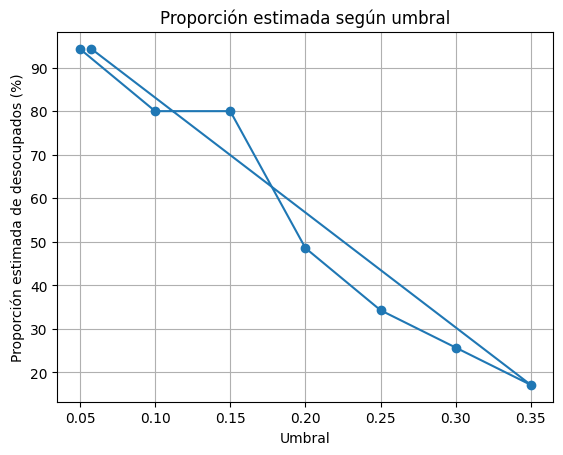

In [41]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Probabilidades predichas para respondieron
probabilidades = logit.predict_proba(X)[:, 1]

# Curva ROC
fpr, tpr, umbrales = roc_curve(y, probabilidades)

# Índice de Youden
youden_index = tpr - fpr
indice_optimo = youden_index.argmax()
umbral_optimo = umbrales[indice_optimo]
print(f"Umbral óptimo según índice de Youden: {umbral_optimo:.3f}")

# Proporción estimada para varios umbrales
umbrales_a_probar = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, umbral_optimo]

print("Umbral\tProporción estimada de desocupados (%)")
for u in umbrales_a_probar:
    noresp_clean["pred_desocupado_temp"] = (noresp_clean["prob_desocupado"] >= u).astype(int)
    prop = noresp_clean["pred_desocupado_temp"].mean() * 100
    print(f"{u:.3f}\t{prop:.2f}")

# Opcional: gráfico de proporción vs umbral
props = []
for u in umbrales_a_probar:
    preds = (noresp_clean["prob_desocupado"] >= u).astype(int)
    props.append(preds.mean() * 100)

plt.plot(umbrales_a_probar, props, marker='o')
plt.xlabel("Umbral")
plt.ylabel("Proporción estimada de desocupados (%)")
plt.title("Proporción estimada según umbral")
plt.grid(True)
plt.show()


Esto significa que el 48.57% de las personas en la base noresp (o sea, los que no respondieron sobre su estado laboral) son estimadas como desocupadas, según el modelo entrenado con los datos de quienes sí respondieron.